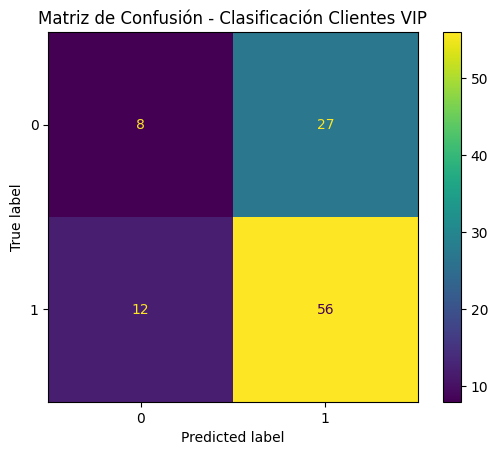

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ==========================================
# 1. Cargar archivos reales
# ==========================================
clientes = pd.read_excel("clientes.xlsx")
ventas = pd.read_excel("ventas.xlsx")
detalle = pd.read_excel("detalle_ventas.xlsx")
productos = pd.read_excel("productos.xlsx")

# ==========================================
# 2. Unificar bases
# ==========================================
df = detalle.merge(
    ventas[['id_venta','id_cliente','fecha','medio_pago']],
    on='id_venta',
    how='left'
).merge(
    clientes[['id_cliente','ciudad']],
    on='id_cliente',
    how='left'
).merge(
    productos[['id_producto','categoria']],
    on='id_producto',
    how='left'
)

# ==========================================
# 3. Crear variable objetivo (cliente VIP)
# Ejemplo: un cliente VIP compra > promedio de la base
# ==========================================
cliente_importe = df.groupby("id_cliente")["importe"].sum().reset_index()
promedio = cliente_importe["importe"].mean()

cliente_importe["VIP"] = (cliente_importe["importe"] > promedio).astype(int)

# Unir de nuevo
df = df.merge(cliente_importe[["id_cliente","VIP"]], on="id_cliente")

# ==========================================
# 4. Seleccionar variables predictoras
# ==========================================
X = df[["cantidad","precio_unitario","categoria","ciudad","medio_pago"]]
y = df["VIP"]

# Categorías → OneHotEncoding
categorical = ["categoria","ciudad","medio_pago"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical)
    ],
    remainder='passthrough'
)

# ==========================================
# 5. Modelo: Regresión Logística
# ==========================================
modelo = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(max_iter=1000))
])

# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

# ==========================================
# 6. Matriz de confusión
# ==========================================
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Matriz de Confusión - Clasificación Clientes VIP")
plt.show()
